In [13]:
#fast test of MPDPS on active matter dataset
import numpy as np
import torch 
import sys
import argparse
import scipy.io as sio
from tqdm import tqdm
sys.path.append("../")
from train_GPSD import EDM
from train_GPSD import create_model
from train_GPSD import get_gp_covariance
from networks_edm import *
from util_posterior_sampling import *
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [14]:
# define hyperparameters 
parser = argparse.ArgumentParser()
parser.add_argument("--expr", type=str, default="sampling", help="experiment name")
parser.add_argument("--dataset", type=str, default="am")
parser.add_argument("--core_mean_std_path", type=str, default="./am_data/core_mean_std.mat")
parser.add_argument("--test_data_path", type=str, default="./am_data/test_am.npy")
parser.add_argument("--basis_path", type=str, default="./am_ckp/basis4_am.pth")
parser.add_argument("--GPSD_path", type=str, default="./am_ckp/GPSD_am.pth")
parser.add_argument('--seed', default=123, type=int, help='global seed')


# EDM models parameters
parser.add_argument('--gt_guide_type', default='l2', type=str, help='gt_guide_type loss type')
parser.add_argument('--sigma_min', default=0.002, type=float, help='sigma_min')
parser.add_argument('--sigma_max', default=80.0, type=float, help='sigma_max')
parser.add_argument('--rho', default=7., type=float, help='Schedule hyper-parameter')
parser.add_argument('--sigma_data', default=0.5, type=float, help='sigma_data used in EDM for c_skip and c_out')
# Sampling parameters
parser.add_argument('--total_steps', default=20, type=int, help='total_steps')
parser.add_argument("--eval_batch_size", type=int, default=64)
parser.add_argument('--begin_ckpt', default=0, type=int, help='begin_ckpt')
# Model architecture
parser.add_argument("--img_size", type=int, default=48)
parser.add_argument('--channels', default=1, type=int, help='input_output_channels')
parser.add_argument('--model_channels', default=40, type=int, help='model_channels')
parser.add_argument('--channel_mult', default=[1,2,2], type=int, nargs='+', help='channel_mult')
parser.add_argument('--attn_resolutions', default=[], type=int, nargs='+', help='attn_resolutions')
parser.add_argument('--num_layers', default=4, type=int,  help='num_layers')
parser.add_argument('--layers_per_block', default=4, type=int, help='num_blocks')
parser.add_argument('--num_temporal_latent', default=8, type=int, help='num_temporal_latent')
config, _ = parser.parse_known_args()

In [15]:
set_seed(config.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.device = device

In [16]:
# init FTM model
basis_function = torch.load(config.basis_path, map_location=device)
basis_function.eval()
basis_function.mode = "sampling"
# init GPSD model
my_net = create_model(config)
edm = EDM(model=my_net, cfg=config)
torch.cuda.empty_cache()# Free any unused GPU memory
edm.model.load_state_dict(torch.load(config.GPSD_path, map_location=device,weights_only=True))
for param in edm.model.parameters(): # freeze GPSD
    param.requires_grad = False
edm.model.eval()

Spatial_temporal_UNet(
  (map_noise): PositionalEmbedding()
  (map_time): FourierEmbedding()
  (map): Sequential(
    (0): Linear(in_features=80, out_features=160, bias=True)
    (1): ReLU()
    (2): Linear(in_features=160, out_features=160, bias=True)
  )
  (map_augment): Linear()
  (map_layer0): Linear()
  (map_layer1): Linear()
  (enc): ModuleDict(
    (48x48_conv): Conv2d()
    (48x48_block0): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
    )
    (48x48_block1): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
    )
    (48x48_block2): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
    )
    (48x48_block3): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): Group

In [17]:
# load core mean and std
d = sio.loadmat(config.core_mean_std_path)
core_mean = torch.tensor(d['core_mean'], dtype=torch.float32).to(device)
core_std = torch.tensor(d['core_std'], dtype=torch.float32).to(device)

In [18]:
# define function: compute gradients from likelihood
def compute_continuous_poest2(x_0, basis_function, core_mean, core_std, core_t, y_group, ind_conti_group, y_time_group,  y_time_ind_group):
    ### input: x_0: estimated clean core 1 * T * R1 * R2 * R3; y_group:observation group;
    #          ind_conti_group: observation index group; t: time index of sampled core; post_t: time index of observation
    ### output: poest_matrix: continuous poestrior matrix
    core_tensor_shape = x_0.shape

    x_0 = x_0.view(core_tensor_shape[0], core_tensor_shape[1], -1) # vectorize [1, T, R1R2R3]
    poest_matrix1 = torch.zeros_like(x_0).to(device)  # Store the posterior gradients of stage1
    poest_matrix2 = torch.zeros_like(x_0).to(device)  # Store the posterior gradients of stage2
    x_0 = x_0 * core_std + core_mean #normalize 
    for y, y_tt, y_t_ind, ind in zip(y_group, y_time_group, y_time_ind_group, ind_conti_group): #A^{H}(y-Ax)
        if y.shape[0] == 0: # Skip if no observations are available for this time step
            continue
        #stage1: compute poesterior gradient for cores at the observation timestep
        x_0_t = x_0[0, y_t_ind, :] # [R1R2R3]
        y = torch.DoubleTensor(y).to(device)#[n]
        ind_conti = torch.FloatTensor(ind).to(device)#[n,3]
        A = basis_function(input_ind_sampl=ind_conti).detach() #[n,T]
        A = A.double()
        poest_matrix1[0, y_t_ind,:] = (A.T @ (y - A @ x_0_t)) # [R1R2R3]
        
        
        #stage2: compute continuos poesterior gradient for all cores 
        t_remove_group = y_time_ind_group.copy()
        t_remove_group.remove(y_t_ind)

        core_t_remove = core_t[:, t_remove_group, :] # [1,T-1]
        x_0_remove = x_0[:, t_remove_group, :] # [1,T-1,R1R2R3]


    

        ktT = get_ktT(y_tt, core_t_remove).squeeze(2) #[1,T-1]
        KTT_inv = get_kTT_inv(core_t_remove) #[T-1, T-1]
        #cov = (ktT @ KTT_inv @ ktT.T).to(device).squeeze()#[1,1]
        coeff = ((ktT @ KTT_inv).to(device)).squeeze(1)#[1,T]
        #coeff = coeff/(torch.abs(coeff).max())
        
        #cov = cov.squeeze() * A  @ A.T
        #cov_inv = cov.inverse() # [n,n]  
        x_0_aggregate = (coeff @ x_0_remove).squeeze()#[R1R2R3]
        post = (A.T @ (y - A @ x_0_aggregate)) # [R1R2R3]
        temp = torch.zeros_like(x_0).to(device)
        temp[:, t_remove_group,:] = torch.kron(coeff.unsqueeze(2), post.unsqueeze(0).unsqueeze(0)) #[1,T-1,R1R2R3]
        poest_matrix2 += temp

    return (poest_matrix1+c*poest_matrix2).view(core_tensor_shape) 


def wrapped_forward(x_hat, i_hat, t):
    return  edm(x_hat, i_hat, t,  use_ema=True).to(torch.float64)


In [19]:
# define function: message-passing posterior sampling
@torch.no_grad()
def edm_post_sampler(
    edm, basis_function, latents, t, y_group, ind_conti_group, y_time_group,  y_time_ind_group, 
    num_steps=18, sigma_min=0.002, sigma_max=80, rho=7,
    use_ema=True, zeta_i = 0.01):
    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, edm.sigma_min)
    sigma_max = min(sigma_max, edm.sigma_max)

    # Diffusion step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=latents.device)
    i_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    i_steps = torch.cat([edm.round_sigma(i_steps), torch.zeros_like(i_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = latents.to(torch.float64) * i_steps[0]

    # cov matrix 
    KTT_inv =  get_kTT_inv(t)
    print("sampling")
    t_start = time.time()

    for i, (i_cur, i_next) in tqdm(enumerate(zip(i_steps[:-1], i_steps[1:]))): # 0, ..., N-1
        x_hat = x_next
        i_hat = i_cur
        
        # Euler step.
        denoised = edm(x_hat, i_hat, t,  use_ema=use_ema).to(torch.float64)
        denoised_core1 = denoised.detach().clone()
        d_cur = (x_hat - denoised) / i_hat
        x_next = x_hat + (i_next - i_hat) * d_cur
        
        x_next1 = x_next
        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = edm(x_next, i_next, t, use_ema=use_ema).to(torch.float64)
            denoised_core2 = denoised.detach().clone()
            #denoised = wrapped_forward(x_hat, i_hat, t)
            def wrapped_forward(x):
                return edm(x.unsqueeze(0), i_next, t, use_ema=use_ema).to(torch.float64)
            

  
            
            d_prime = (x_next - denoised) / i_next
            x_next = x_hat + (i_next - i_hat) * (0.5 * d_cur + 0.5 * d_prime)

            #Add llk_grad
            denoised_core = (denoised_core1 + denoised_core2) / 2
            llk_grad2 = compute_continuous_poest2(denoised_core, basis_function, core_mean, core_std, t, y_group, ind_conti_group, y_time_group, y_time_ind_group)
            x_next = x_next + (zeta/(i+1))*llk_grad2
          
      



    t_end = time.time()
    print(f"Elapsed time: {t_end - t_start:.4f} seconds")
    print("sampling ",num_steps," steps completed")
    return x_next


In [20]:
# load test data
test_data = np.load(config.test_data_path) 
print(test_data.shape)

(4, 24, 1, 256, 256)


### Visualize ground truth test data

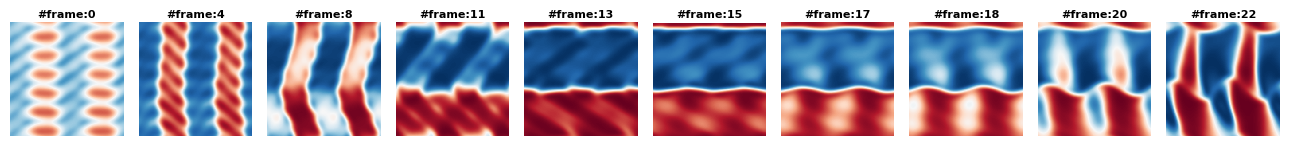

In [84]:
# visualize ground truth of test data
import seaborn as sns
import matplotlib.pyplot as plt
ind_test = 2  # the index of test data
test_sample = test_data[ind_test]
vmin = test_sample.min()
vmax = test_sample.max()
cmap = plt.cm.RdBu_r
temporal_ind=[0,4,8,11,13,15,17,18,20,22]
fig, axs = plt.subplots(1,10, figsize=(13,1.5), sharex=True, sharey=True)
for i,j in enumerate(temporal_ind):
    sns.heatmap(test_sample[j, 0, :, :], cmap=cmap, ax=axs[i], cbar=False, square=True, shading="auto", vmin=vmin, vmax=vmax)
    axs[i].set_title(f"#frame:{j}", fontsize=8, rotation=0,  fontweight='bold',  va='center')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.tight_layout()
plt.show()

### Visualize observations

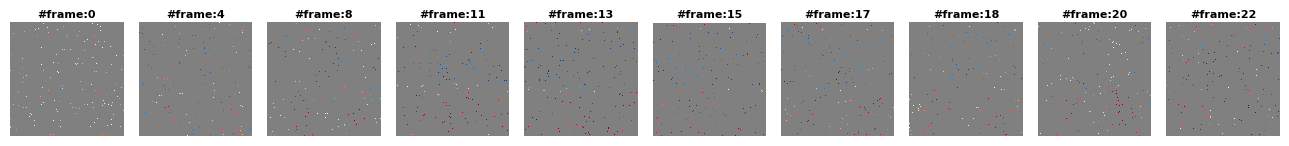

In [85]:
# construct observations
rho = 0.01 # observation rate
mt = 0 # observation mode type
data_extract, mask, y_group, ind_conti_group, y_time_group, y_time_ind_group, u_ind_uni, v_ind_uni, w_ind_uni = get_te_observations(test_data, rho=rho, mode=mt, ind=ind_test)
# visual observations 
test_sample1 = test_sample + 5 
vmin1 = test_sample1.min()
vmax1 = test_sample1.max()
test_ob = test_sample1*mask
cmap1 = cmap.copy()
cmap1.set_under(color='gray')
fig, axs = plt.subplots(1,10, figsize=(13,1.5), sharex=True, sharey=True)
for i,j in enumerate(temporal_ind):
    sns.heatmap(test_ob[j, 0, :, :], cmap=cmap1, ax=axs[i], cbar=False, square=True, shading="auto", vmin=vmin1, vmax=vmax1)
    axs[i].set_title(f"#frame:{j}", fontsize=8, rotation=0,  fontweight='bold',  va='center')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.tight_layout()
plt.show()

### Peform message-passing posterior sampling

In [86]:
# posterior sampling with the gradients guidance from observations
c = 0.45 # coefficient of mpdps: if set to 0, it degrade into DPS
zeta = 0.01 

basis_function.mode = "sampling"
sample_shape= [1,test_data.shape[-4],1,48,48]
t_grid = (torch.linspace(0, 1, sample_shape[1]).view(1, -1, 1).to(device)).repeat(sample_shape[0], 1, 1)
t_grid = t_grid.double()
cov_sample = get_gp_covariance(t_grid)
L_sample = torch.linalg.cholesky(cov_sample).to(device)
noise_sample = torch.randn(sample_shape).to(device).double()

x_T = (L_sample @ noise_sample.view(sample_shape[0], sample_shape[1],-1) ).view(sample_shape) # X_T
sample = edm_post_sampler(edm, basis_function, x_T, t_grid, y_group, ind_conti_group, y_time_group, y_time_ind_group, num_steps=config.total_steps, use_ema=False).detach()
core_sample = (sample*core_std + core_mean)
out = decoder(u_ind_uni, v_ind_uni,w_ind_uni, core_sample[0], basis_function, device) # decode into data space

rmse = np.sqrt(np.mean((out - data_extract)**2))
print("RMSE:", rmse)


sampling


20it [00:05,  3.68it/s]

Elapsed time: 5.4383 seconds
sampling  20  steps completed
RMSE: 0.18467742


### Visualize reconstructions

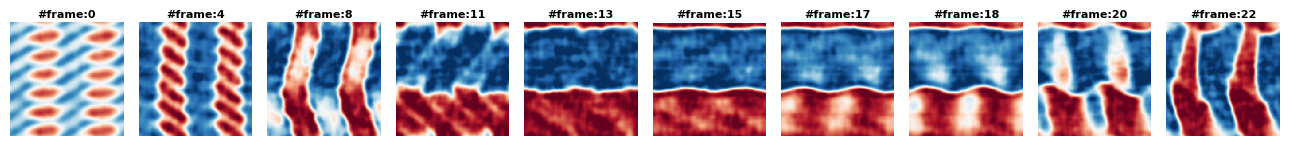

In [87]:
fig, axs = plt.subplots(1,10, figsize=(13,1.5), sharex=True, sharey=True)
for i,j in enumerate(temporal_ind):
    sns.heatmap(out[j, 0, :, :], cmap=cmap, ax=axs[i], cbar=False, square=True, shading="auto", vmin=vmin, vmax=vmax)
    axs[i].set_title(f"#frame:{j}", fontsize=8, rotation=0,  fontweight='bold',  va='center')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.tight_layout()
plt.show()